In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Prepare the dataset
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean & std of MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 28.9k/28.9k [00:00<00:00, 512kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.31MB/s]


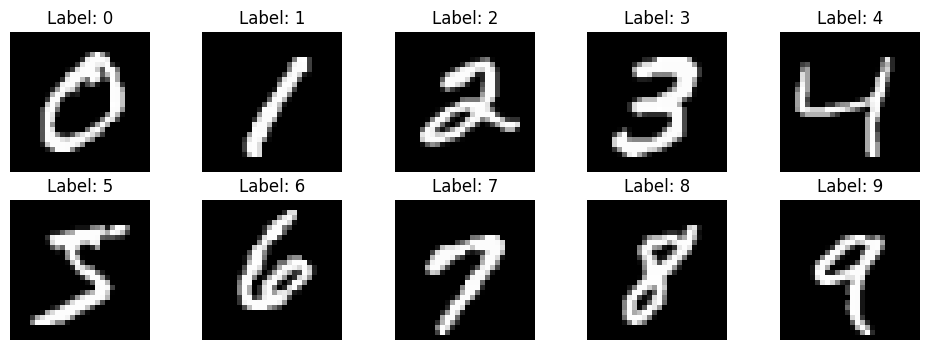

In [4]:
# Display the image from each class

class_images = {}

for img, label in train_dataset:
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == 10:  # got all classes
        break

plt.figure(figsize=(12, 4))
for i in range(10):
    img = class_images[i].squeeze().numpy()  # remove channel dim
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {i}")
    plt.axis("off")

plt.show()

In [5]:
# Define CNN model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # output: 64x14x14
        self.pool = nn.MaxPool2d(2, 2)  # downsample by 2
        self.fc1 = nn.Linear(64*7*7, 128)   # flatten to fully connected
        self.fc2 = nn.Linear(128, 10)       # 10 output classes (digits 0–9)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        #x = self.pool(F.relu(self.conv1(x)))   # conv1 -> relu -> pool
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        #x = self.pool(F.relu(self.conv2(x)))   # conv2 -> relu -> pool
        x = x.view(-1, 64*7*7)                  # flatten
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.relu(self.fc1(x))                # fully connected
        x = self.fc2(x)                        # output layer
        return x

In [6]:
# Training phase

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()    # softmax + log loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.4f}")

In [7]:
# Test the model
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

In [8]:
# Train and test the model
for epoch in range(1, 3):  # 5 epochs
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader, criterion)

Epoch 1 [0/60000]  Loss: 2.2948
Epoch 1 [6400/60000]  Loss: 0.1262
Epoch 1 [12800/60000]  Loss: 0.1238
Epoch 1 [19200/60000]  Loss: 0.0348
Epoch 1 [25600/60000]  Loss: 0.0223
Epoch 1 [32000/60000]  Loss: 0.0873
Epoch 1 [38400/60000]  Loss: 0.0186
Epoch 1 [44800/60000]  Loss: 0.0280
Epoch 1 [51200/60000]  Loss: 0.1072
Epoch 1 [57600/60000]  Loss: 0.0130

Test set: Average loss: 0.0000, Accuracy: 9856/10000 (98.56%)

Epoch 2 [0/60000]  Loss: 0.0945
Epoch 2 [6400/60000]  Loss: 0.0523
Epoch 2 [12800/60000]  Loss: 0.0553
Epoch 2 [19200/60000]  Loss: 0.0077
Epoch 2 [25600/60000]  Loss: 0.0412
Epoch 2 [32000/60000]  Loss: 0.0076
Epoch 2 [38400/60000]  Loss: 0.0292
Epoch 2 [44800/60000]  Loss: 0.0034
Epoch 2 [51200/60000]  Loss: 0.0862
Epoch 2 [57600/60000]  Loss: 0.0104

Test set: Average loss: 0.0000, Accuracy: 9860/10000 (98.60%)



True label: 7


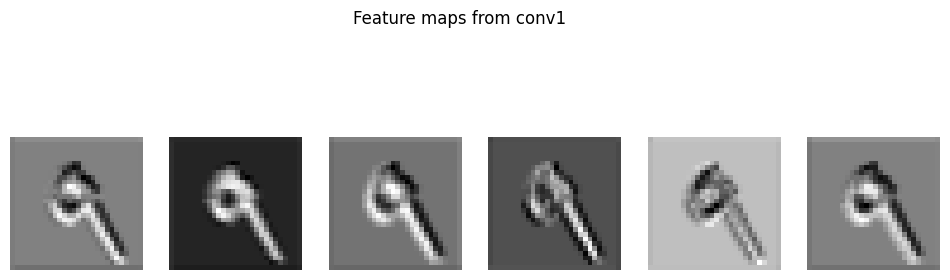

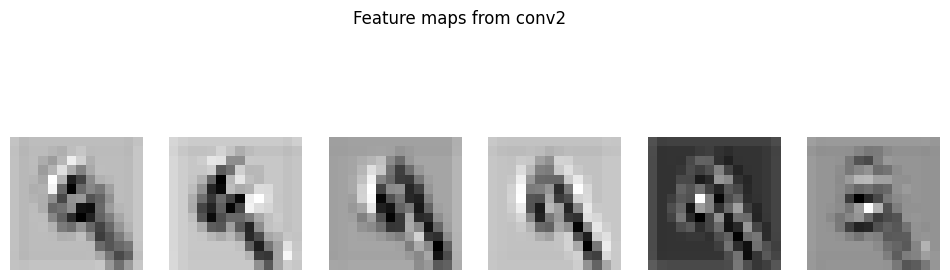

In [11]:
# Plot the feature mapes after the model training gets over

example_data, example_target = next(iter(test_loader))
example_data = example_data[7].unsqueeze(0).to(device)  # take first image
print(f"True label: {example_target[0].item()}")

activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().cpu()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))


_ = model(example_data)


def plot_feature_maps(layer_name, num_maps=6):
    fmap = activation[layer_name][0]  # shape: [C, H, W]
    plt.figure(figsize=(12, 4))
    for i in range(min(num_maps, fmap.shape[0])):  # show first few maps
        plt.subplot(1, num_maps, i+1)
        plt.imshow(fmap[i], cmap='gray')
        plt.axis("off")
    plt.suptitle(f"Feature maps from {layer_name}")
    plt.show()

plot_feature_maps('conv1', num_maps=6)  # show 6 maps from conv1
plot_feature_maps('conv2', num_maps=6)  # show 6 maps from conv2
